# FFT-FFN Model -- DEPRECATED

Build a FeedForward Network to learn a representation of the Fourier transformed Time Series Data (presumably built to learn/recreate signals without the time series component in LSTMs)


<BR>


**Links + Resources**
- Autoencoder Example- https://www.tensorflow.org/tutorials/generative/autoencoder#first_example_basic_autoencoder (uses a combination of model and sequential APIs in tf)
- Interpretation of Fourier Amplitudes- https://dsp.stackexchange.com/questions/62908/interpreting-the-amplitude-of-signals-in-fourier-transform (background information, useful to think about)



In [1]:
import os 
import random
import numpy as np 
import time
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

# from StockData import * 
from StockDataToGinis import * 

# for reproducible results
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # tf.keras.utils.set_random_seed(seed) #alt version of tf
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [2]:
# Read in Saved TSVs of Array Data & Reshape

stock_data = "../Data Quality (Stocks)/Stocks_Cleaned.csv"
WINDOW_LEN = 20

X_train = np.loadtxt("autoencoder_data/train.tsv")
X_test = np.loadtxt("autoencoder_data/test.tsv")

# Shape of Data to Read in for Linear Autoencoder (keeping same as LSTM even if need not be)
X_train = X_train.reshape(9980, 1, 20)
X_test = X_test.reshape(20, 1, 20)
X_test_original = np.copy(X_test) #for testing reconstruction against original sequence

# Get Train & Val Splits
X_val = X_train[-100:] #val needs go first! (train gets reassigned)
X_train = X_train[:-100]


In [3]:
# Normalization -- MinMax Transformation + Inverse Fourier
from sklearn.preprocessing import MinMaxScaler
from numpy.fft import fft, ifft

# Instantiate Scalers & Fit to Train Set
# X_mms = MinMaxScaler()
# X_mms.fit(X_train[:, 0, :])

# X_train = X_mms.transform(X_train[:, 0, :])
# X_train = X_train.reshape((len(X_train), 1, WINDOW_LEN)) #cheeky reshape, dims for LSTM input

# X_test = X_mms.transform(X_test[:, 0, :])
# X_test = X_test.reshape((len(X_test), 1, WINDOW_LEN)) #cheeky reshape, dims for LSTM input

# X_total = X_mms.transform(X_total[:, 0, :])
# X_total = X_total.reshape((len(X_total), 1, WINDOW_LEN))


# Apply Fourier (in Utils for Data Load in) -- built for TS-LSTM shape (9980, 1, 20) = (n_instances, n_periods, n_features per period)
print("Read Sequence\n", X_train[0], "\n")
X_train = fourier_transform(X_train, inverse=False)
X_val = fourier_transform(X_val, inverse=False)
X_test = fourier_transform(X_test, inverse=False)
# X_total = fourier_transform(X_total, inverse=False)


# Convert ndarrays to tf tensors -- tf acts up if left in np, or try to convert in Model Call
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test  = tf.convert_to_tensor(X_test, dtype=tf.float32)
# X_total = tf.convert_to_tensor(X_total, dtype=tf.float32)


# Convert Train & Val Splits into TensorFlow Datasets (easy batch iteration)
batch_size = 10 #good size for this dataset (sufficient updates for time taken)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train))
train_dataset = train_dataset.shuffle(buffer_size=10000, seed=42).batch(batch_size) #perfect shuffling, will sample from all data points

val_dataset = tf.data.Dataset.from_tensor_slices((X_val))
val_dataset = val_dataset.batch(batch_size)


Read Sequence
 [[0.63252811 0.63557236 0.6224634  0.6224634  0.6159009  0.65165384
  0.62892987 0.6308616  0.60959703 0.63096071 0.61271813 0.62247148
  0.6248995  0.68342284 0.65796282 0.65714937 0.65714937 0.63832884
  0.62914625 0.63628406]] 

Transformed
 [[ 1.27004639e+01+0.j          1.54578063e-02+0.13821472j
  -1.19086341e-01-0.03050926j  8.74240829e-02-0.01104377j
   3.08894661e-02+0.01363572j -1.11455678e-02-0.07070869j
   1.91304536e-02+0.04700399j -3.59831114e-02+0.02975842j
   4.00221365e-03-0.02847396j  4.32966788e-02-0.02131377j
  -1.17873114e-01+0.j          4.32966788e-02+0.02131377j
   4.00221365e-03+0.02847396j -3.59831114e-02-0.02975842j
   1.91304536e-02-0.04700399j -1.11455678e-02+0.07070869j
   3.08894661e-02-0.01363572j  8.74240829e-02+0.01104377j
  -1.19086341e-01+0.03050926j  1.54578063e-02-0.13821472j]] 

Transformed
 [[ 1.20085347e+01+0.00000000e+00j -5.98260908e-02-3.27406721e-03j
   1.19500374e-02-7.76770895e-02j -8.58045062e-03-5.49705205e-02j
  -3.770609

2022-05-03 19:33:22.013484: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ckg-files/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


## Linear Autoencoder Architecture

In [18]:
# Autoencoder Architecture -- AS SIMILAR TO TS-LSTM AS POSSIBLE
class FFT_FFN(Model):
  @tf.autograph.experimental.do_not_convert
  def __init__(self, latent_large, latent_small):
    super(FFT_FFN, self).__init__()

    # Sizes for Large & Small Layers in Encoder/Decoder
    self.latent_large = latent_large
    self.latent_small = latent_small
      
    self.encoder = tf.keras.Sequential([
      layers.Dense(20, name="input"), #input layer
      layers.Dense(latent_large, activation='relu', name="dense-1"), #can convert back into dense layers -- need experiment 
      layers.Dense(latent_small, activation='relu', name="dense-2")
                                        ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(latent_small, activation='relu', name="dense-3"),
      layers.Dense(latent_large, activation='relu', name="dense-4"),
      layers.Dense(20, activation='relu') #output effectively (20 value, reconstructed sequence), activation typically used here is sigmoid
                                        ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded




# Root Mean Squared Loss -- Using Keras Provided instead 
def rmse_loss(target_y, predicted_y):
  return tf.matrix_square_root(tf.reduce_mean(tf.square(target_y - predicted_y))) 
  # return tf.reduce_mean(tf.square(target_y - predicted_y)) #original MSE loss function


# Macro Training Func w Batches & Epochs (wraps forward pass/backprop in step)
def train(epochs=int, model=None, save_best=False):
  history = {"train":[], "val":[], "test":[]} #hold eval metrics for plotting
  best_test_acc = 0 #if saving best test set accuracy model weights

  for epoch in range(epochs):
    start_time = time.time()

    # Iter through Batches
    for i, x_batch_training in enumerate(train_dataset):

      loss = train_step(x_batch_training, model)

    train_acc = train_acc_metric.result() #return training results from batches


    # Run Validation Loop per Epoch
    for x_batch_val in val_dataset:
        val_reconstruction = val_step(x_batch_val, model)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()

    # Eval on Test Reconstruction per Epoch
    _, test_acc = reconstruction_accuracy(X_test, model, show=False)

    # Print Accuracies
    print(f"Epoch {epoch} - Time: {(time.time() - start_time):.2f}s")
    print(f"Train: {float(train_acc):.4f} - Val: {float(val_acc):.4f} - Test: {float(test_acc):.4f}\n")

    # Append Results to Dict & Reset Metric States
    history["train"].append(float(train_acc))
    history["val"].append(float(val_acc))
    history["test"].append(float(test_acc))

    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

    # Save Best Models Weights from Training
    if save_best:
      if best_test_acc <= test_acc:
        model.save('models/TS-LSTM/')
        print("Saved new Best Model")


  history["epochs"] = [i for i in range(0, epochs)] 
  return history


##-- Step Funcs, Static Compiled for 10x Speed Up --##

# Forward & Backward Pass on Model 
@tf.function #decorator does static compiling, 10x faster
@tf.autograph.experimental.do_not_convert
def train_step(x, model):
  with tf.GradientTape() as tape:

    # Forward Pass
    x_reconstruction = model(x)

    # Compute Loss
    loss = loss_fn(x_reconstruction, x)

  # Get Gradients wrt Loss
  grads = tape.gradient(loss, model.trainable_weights)

  # Backprop w Gradient Descent
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  train_acc_metric.update_state(x, x_reconstruction) #update training metric per batch
  return loss

# Validation Step -- compiled for 10x speedup
@tf.function
@tf.autograph.experimental.do_not_convert
def val_step(x, model):
  val_reconstruction = model(x)
  # Update val metrics
  val_acc_metric.update_state(x, val_reconstruction)
  return val_reconstruction


##-- TEST SET EVALUATION FUNCTIONS --##

# Test Reconstruction Accuracy Func -- Gauge Autoencoder performance on a Test Set
def reconstruction_accuracy(testset, model, show=True):
    # Get Preds for Test
    h = model.encoder(testset).numpy()
    decoded = model.decoder(h).numpy()

    # Get Error Statistics
    mse = (np.sum(testset-decoded)**2)/len(decoded)
    mse = float(mse)
    rmse = np.sqrt(mse)
    
    avg_rmse = rmse/len(decoded)

    if show:
        print(f"Total RMSE for Entire Set: {100 * rmse:.2f}%\n  Average RMSE per Example: {100 * avg_rmse:.2f}%")
    else:
        return rmse, avg_rmse

# Plot Sequences from Test Set (Visual Evaluation of Reconstructions)
def plot_reconstruction(model, test_set, indicies):
    # Get Preds
    encoded_data = model.encoder(test_set).numpy()
    decoded_data = model.decoder(encoded_data).numpy()

    # Generate Plots
    print("Recreations of Original Signals")
    for i in indicies: #change this for different curves
        x_pred_plot = decoded_data[i]
        x_test_plot = X_test[i].numpy().reshape(-1)

        # Inverse Transform -- need reshape twice, MinMaxScaler expects mulit-dim array & Plotter needs 1d array
        # x_pred_plot = X_mms.inverse_transform(x_pred_plot.reshape(1, 20)).reshape(-1)
        x_pred_plot = x_pred_plot.reshape(1, 20).reshape(-1)

        # x_test_plot = X_mms.inverse_transform(x_test_plot.reshape(1, 20)).reshape(-1) 
        x_test_plot = x_test_plot.reshape(1, 20).reshape(-1)

        # Get Error Statistics
        mse = (np.sum(x_test_plot - x_pred_plot)**2)/len(x_test_plot)
        rmse = float(np.sqrt(mse))

        # Plot Difference Curves
        plt.plot(x_test_plot, "#56B9FF")
        plt.plot(x_pred_plot, '#ABE9B3')
        plt.fill_between(np.arange(20), x_pred_plot, x_test_plot, color='#F28FAD', alpha=0.5)
        plt.legend(labels=["Original", "Reconstructed", "Error"])

        plt.title(f"Index: {i} - RMSE: {100 * rmse:.2f}%")
        plt.xlabel("Time (Days)")
        plt.ylabel("Gini")
        plt.show()

    return


# Test Reconstruction Accuracy on Original Sequence
def original_reconstruction_accuracy(testset, preds, show=True):

    # Inverse Transform into original domain 
    preds = fourier_transform(preds, inverse=True)

    # Get Error Statistics
    mse = (np.sum(testset-preds)**2)/len(preds) #testset is intended to be ORIGINAL `X_test`, before transform
    mse = float(mse)
    rmse = np.sqrt(mse)
    
    avg_rmse = rmse/len(preds)

    if show:
        print(f"Total RMSE for Entire Set: {100 * rmse:.2f}%\n  Average RMSE per Example: {100 * avg_rmse:.2f}%")
    else:
        return rmse, avg_rmse



# Instantiate Autoencoder
set_seeds(seed=42)

autoencoder = FFT_FFN(latent_large=50, latent_small=20)
optimizer = tf.keras.optimizers.Adam(lr=1e-1) # LINEAR NEEDED A LARGER LEARNING RATE! 10x larger than LSTM
loss_fn = keras.losses.MeanSquaredError()
autoencoder.compile(optimizer=optimizer, loss=loss_fn)

# Train & Val Metrics
train_acc_metric = keras.metrics.RootMeanSquaredError()
val_acc_metric = keras.metrics.RootMeanSquaredError()

# Build & Summarize Model
autoencoder.build(input_shape=X_train.shape)
autoencoder.summary()

Model: "fft_ffn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (9880, 1, 20)             2490      
                                                                 
 sequential_5 (Sequential)   (9880, 1, 20)             2490      
                                                                 
Total params: 4,980
Trainable params: 4,980
Non-trainable params: 0
_________________________________________________________________


/Users/ckg-files/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


- **Dense Layers have about 7.5x less parameters than same sized layers in LSTM model**

In [8]:
# Run Training

n_epochs = 50
batch_size = 10 #10 seems to be a good size for this dataset (accuracy & n of gradient updates)
set_seeds() #reproducibility!


history = train(n_epochs, autoencoder)

Epoch 0 - Time: 1.32s
Train: 0.5524 - Val: 0.0724 - Test: 0.0335

Epoch 1 - Time: 0.80s
Train: 0.0660 - Val: 0.0592 - Test: 0.0110

Epoch 2 - Time: 0.82s
Train: 0.0840 - Val: 0.0671 - Test: 0.0503

Epoch 3 - Time: 0.88s
Train: 0.0833 - Val: 0.0669 - Test: 0.0436

Epoch 4 - Time: 0.82s
Train: 0.0766 - Val: 0.0576 - Test: 0.0257

Epoch 5 - Time: 0.83s
Train: 0.3836 - Val: 0.1136 - Test: 0.0073

Epoch 6 - Time: 0.81s
Train: 0.1192 - Val: 0.1105 - Test: 0.0217

Epoch 7 - Time: 0.82s
Train: 0.1176 - Val: 0.1093 - Test: 0.0442

Epoch 8 - Time: 0.81s
Train: 0.1192 - Val: 0.1095 - Test: 0.0315

Epoch 9 - Time: 0.99s
Train: 0.1190 - Val: 0.1142 - Test: 0.0054

Epoch 10 - Time: 0.86s
Train: 0.1179 - Val: 0.1094 - Test: 0.0325

Epoch 11 - Time: 0.86s
Train: 0.1173 - Val: 0.1098 - Test: 0.0505

Epoch 12 - Time: 1.13s
Train: 0.1163 - Val: 0.1120 - Test: 0.0139

Epoch 13 - Time: 1.28s
Train: 0.1155 - Val: 0.1111 - Test: 0.0185

Epoch 14 - Time: 1.18s
Train: 0.1160 - Val: 0.1096 - Test: 0.0291

Epoch

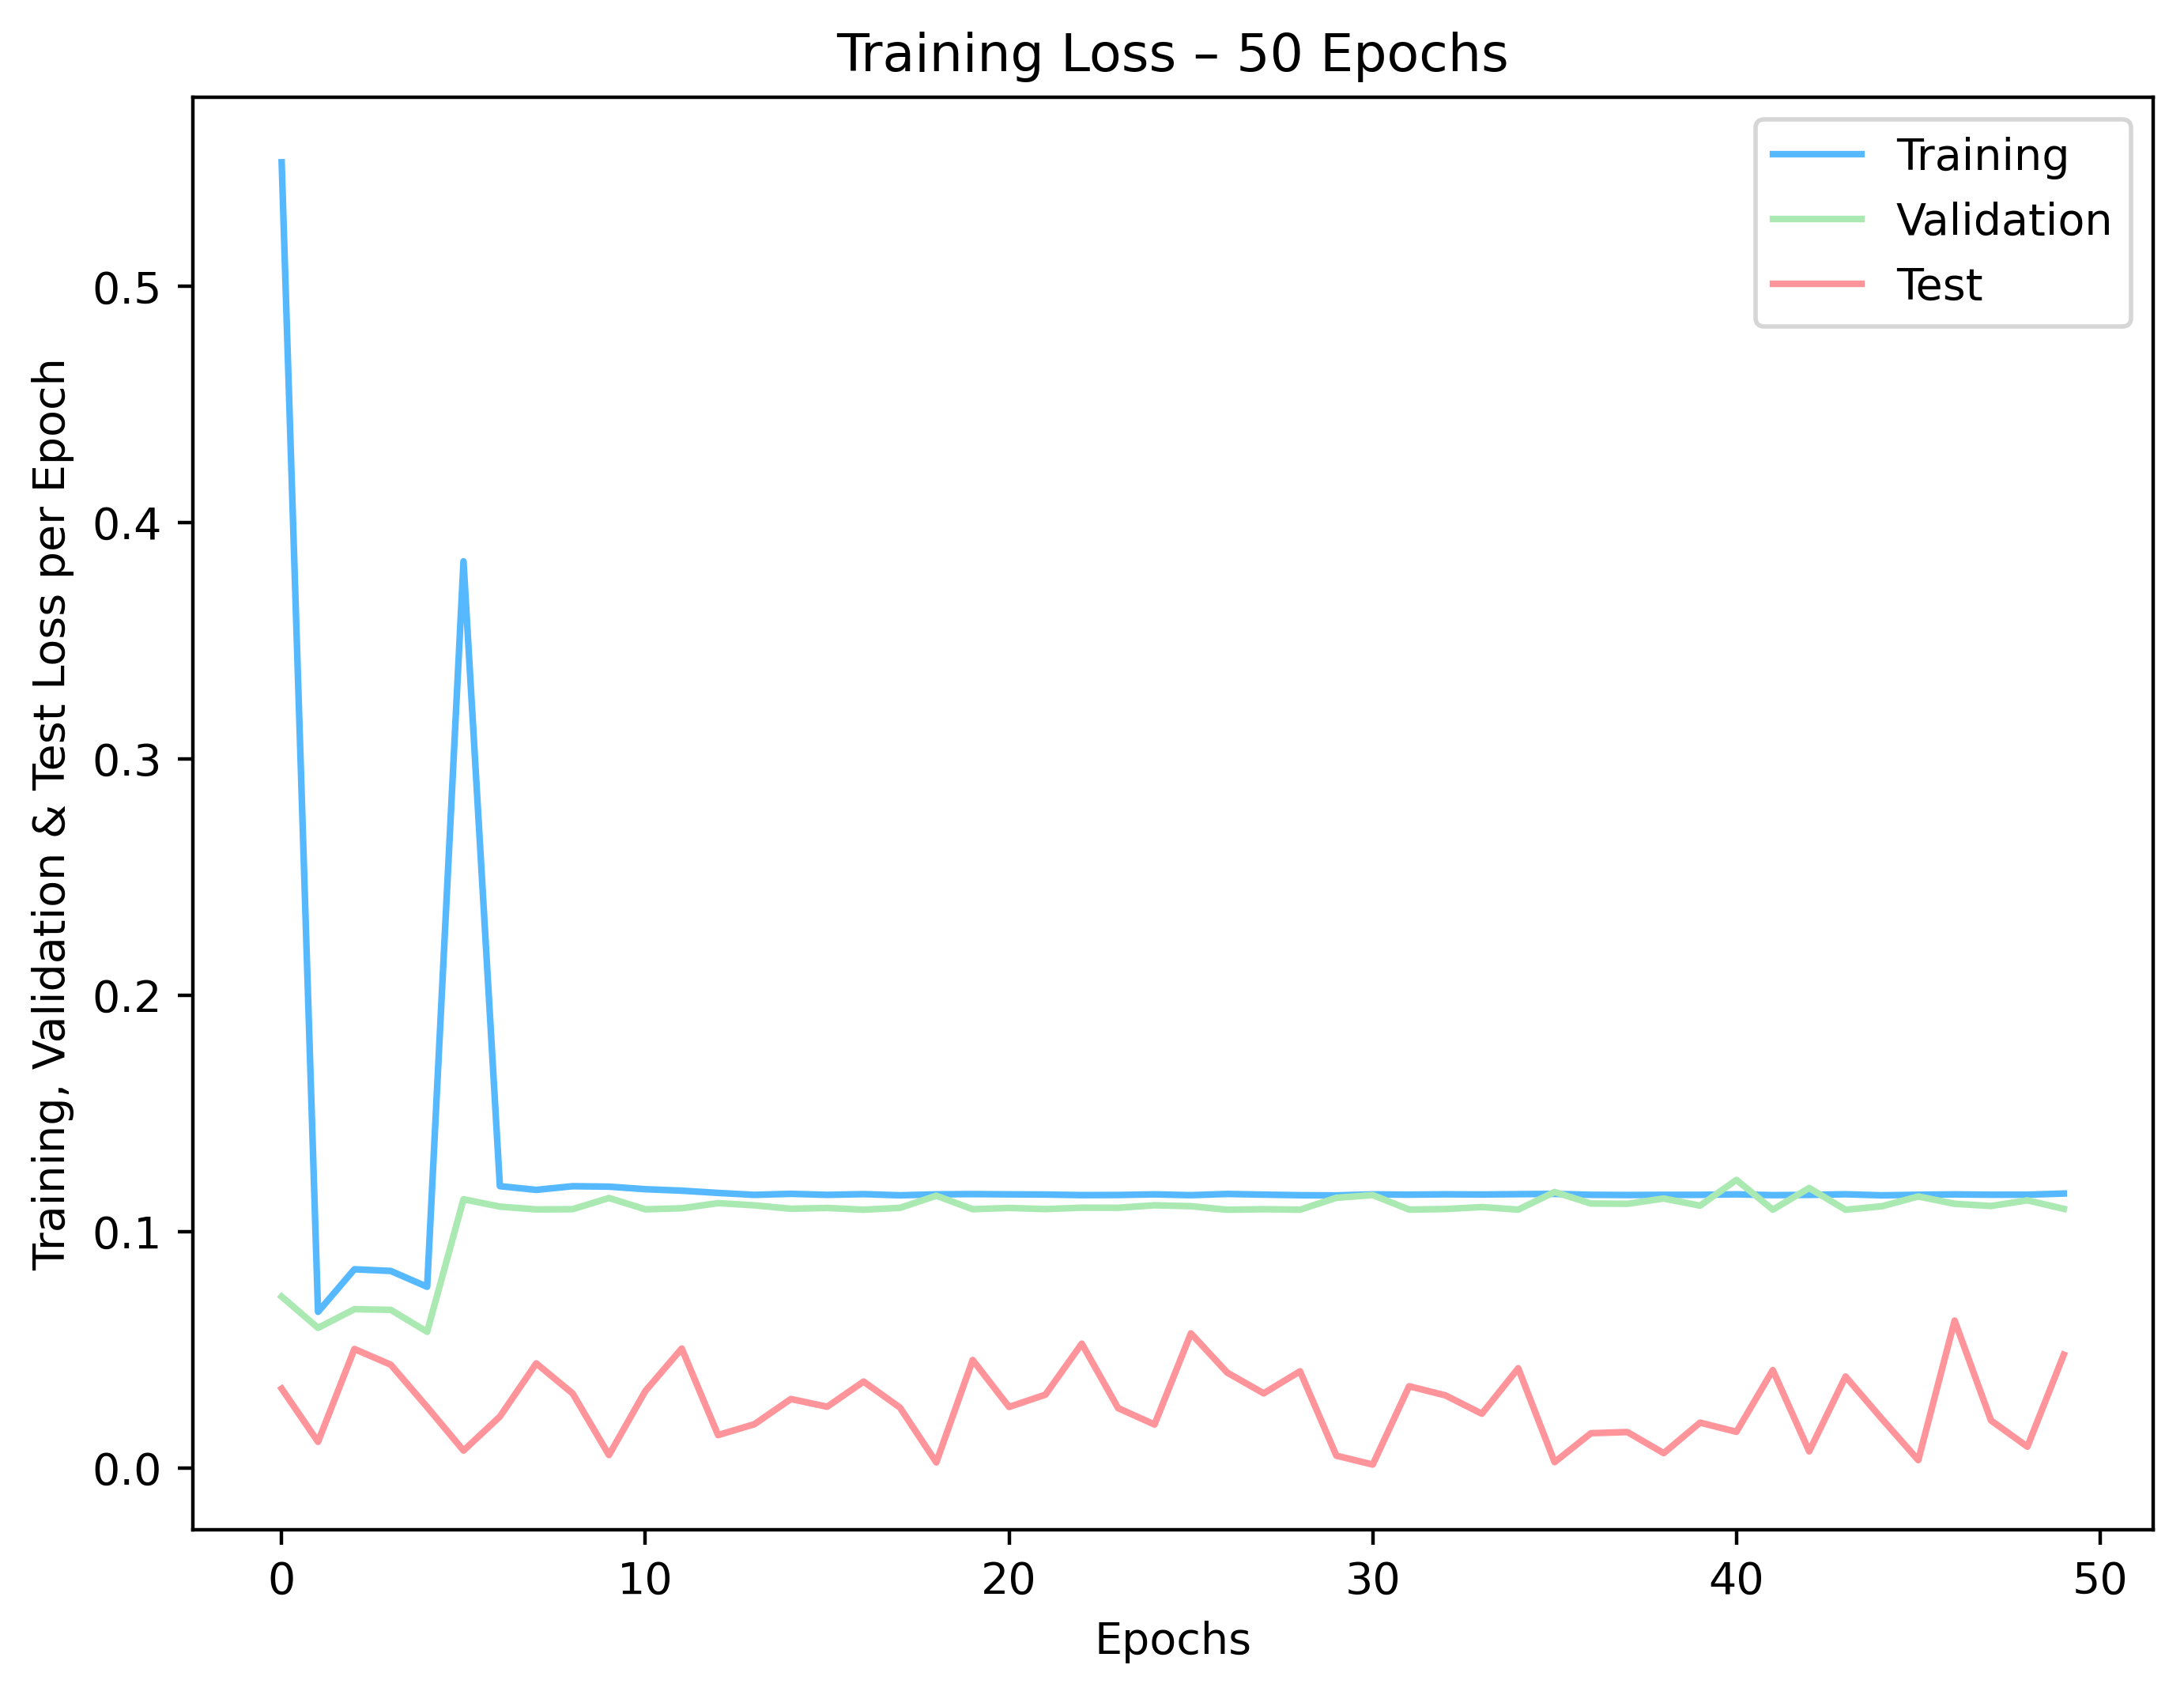

In [9]:
# Plot History from Model Training -- Accuracy of Recreation
import matplotlib.pyplot as plt 

plt.style.use('seaborn-pastel') # "seaborn-pastel" or "dark_background"
plt.figure(figsize=(8, 6), dpi=400)
plt.title(f"Training Loss – {n_epochs} Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training, Validation & Test Loss per Epoch")

plt.plot(range(n_epochs), history["train"], color="#56B9FF", label="Training")
plt.plot(range(n_epochs), history["val"],   color="#ABE9B3", label="Validation")
plt.plot(range(n_epochs), history["test"],  color="#FF949A", label="Test")
plt.legend(loc="best")



## Evaluation of Model

- Reconstruction Accuracy on Entire Set
- Plot Reconstructions against original sequences

In [26]:
# Need Inverse Transform preds -- moved to `plot_reconstruction function`

In [10]:
autoencoder(X_test)

<tf.Tensor: shape=(20, 1, 20), dtype=float32, numpy=
array([[[11.926813,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ]],

       [[11.926813,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ]],

       [[11.926813,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ]],

       [[11.926813,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
          0.      ,  0.      ,  0.      , 

In [21]:
reconstruction_accuracy(X_test, autoencoder) #run pass on test set, get RMSE Accuracy 



original_reconstruction_accuracy(X_test_original, xt)

Total RMSE for Entire Set: 4472.53%
  Average RMSE per Example: 223.63%
Inverse Transform
 [[6.46314669e-01 8.89340881e-04 2.08279770e-03 1.14671979e-03
  2.75913551e-03 1.45116942e-03 2.49407329e-03 8.36192910e-04
  1.91457719e-03 5.50233014e-04 2.59318016e-03 5.50233014e-04
  1.91457719e-03 8.36192910e-04 2.49407329e-03 1.45116942e-03
  2.75913551e-03 1.14671979e-03 2.08279770e-03 8.89340881e-04]] 

Total RMSE for Entire Set: 5134.35%
  Average RMSE per Example: 256.72%


Recreations of Original Signals


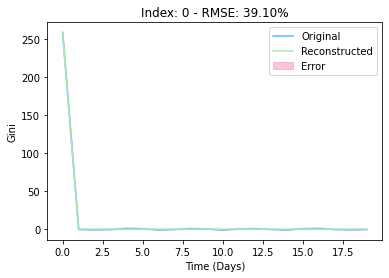

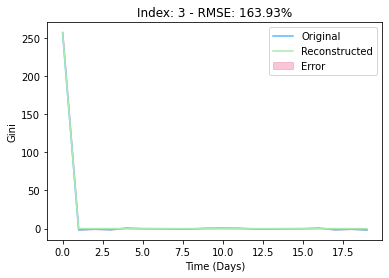

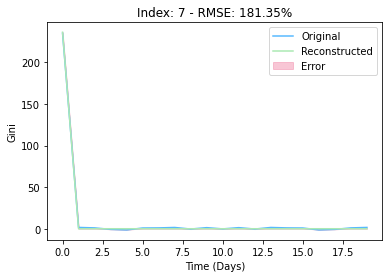

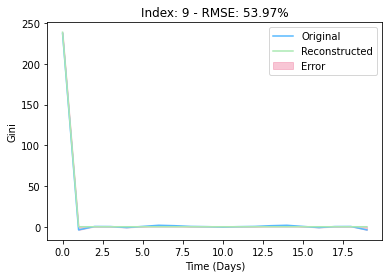

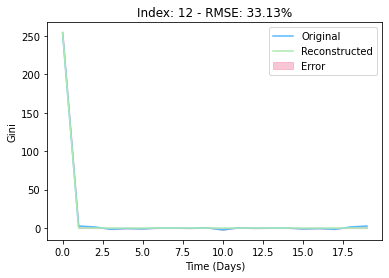

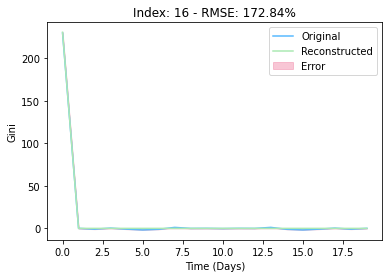

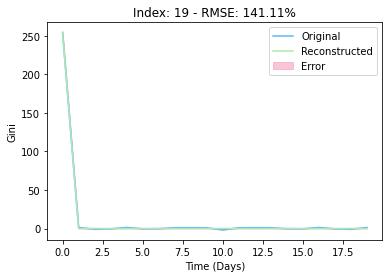

In [50]:
# View Difference Between Sequence (Multi Examples)

# plot_reconstruction(autoencoder, X_test, range(0, 20)) #plot all 
plot_reconstruction(autoencoder, X_test, [0, 3, 7, 9, 12, 16, 19]) #plot specified subset

